<a href="https://colab.research.google.com/github/olodenm/info_2022_olo/blob/Netology_HW/%D0%9A%D0%B5%D0%B9%D1%81_%D1%81%D1%82%D0%B0%D0%B4%D0%B8_%D0%A1%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

##Задание 1
Вернемся к [набору данных о видеоиграх](https://github.com/obulygin/pyda_homeworks/blob/master/stat_case_study/vgsales.csv)

Ответьте на следующие вопросы:

1. Как критики относятся к спортивным играм?
2. Критикам нравятся больше игры на PC или на PS4?
3. Критикам больше нравятся стрелялки или стратегии?

In [ ]:
# скачиваем исходный df
! wget https://raw.githubusercontent.com/obulygin/pyda_homeworks/master/stat_case_study/vgsales.csv

--2023-11-22 18:48:59--  https://raw.githubusercontent.com/obulygin/pyda_homeworks/master/stat_case_study/vgsales.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1618040 (1.5M) [text/plain]
Saving to: ‘vgsales.csv’

vgsales.csv         100%[===================>]   1.54M  6.60MB/s    in 0.2s    

2023-11-22 18:48:59 (6.60 MB/s) - ‘vgsales.csv’ saved [1618040/1618040]



In [ ]:
df = pd.read_csv('/content/vgsales.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


### 1) Как критики относятся к спортивным играм?
 1. **H0:** Средние оценки критиков для спортивных игр и игр других жанров равны.
 2. **H1:** Средние оценки критиков для спортивных игр и игр других жанров отличаются.
 3. **alpha** = $0.05$
 4. Воспользуемся одновыборочным <u>t-test</u> для сравнения среднего значения в выборке

In [ ]:
alpha = 0.05

In [ ]:
# Фильтруем df для по жанру = спорт
critic_score_sport = df[df['Genre'] == 'Sports']

# Вычисляем дисперсию оценок критиков для спортивных игр
var_critic_score_sport = critic_score_sport['Critic_Score'].var() # 192.610889035847

# Задаем уровень доверия и допустимую ошибку
conf = 0.95
delta = 5

# Вычисляем необходимый размер выборки
z = stats.norm.ppf(1 - (1 - conf) / 2)
n_required = int(np.ceil(((z / delta) ** 2) * var_critic_score_sport))

# Проверяем, достаточен ли размер выборки для проведения теста
if len(critic_score_sport['Critic_Score'].dropna()) >= n_required:
    # Проводим одновыборочный t-тест
    stat, p = stats.ttest_1samp(a=critic_score_sport['Critic_Score'].dropna(), popmean=df['Critic_Score'].mean())

    # Выводим результаты теста
    print(f'T-статистика: {stat}')
    print(f'P-значение: {p}') # 0.0000000000001538088875231057
    if p > alpha:
        print('Не отклоняем нулевую гипотезу. Критики относятся к спортивным играм, вероятно, так же как и ко всем остальным')
    else:
        print('Oтклоняем нулевую гипотезу. Отношение критиков к спортивным играм, вероятно, отличается от отношения ко всем остальным играм.')
else:
    print(f'Недостаточно данных. Требуется минимум {n_required} оценок критиков для спортивных игр для проведения теста.')

T-статистика: 7.470587451672032
P-значение: 1.538088875231057e-13
Oтклоняем нулевую гипотезу. Отношение критиков к спортивным играм, вероятно, отличается от отношения ко всем остальным играм.


### 2) Критикам нравятся больше игры на PC или на PS4?
1. **H0:** Средние оценки критиков для игр на PC и PS4 равны.
2. **H1:** Средние оценки критиков для игр на PC отличаются от средних оценок для игр на PS4.
3. **alpha** = $0.05$
4. Используем двухвыборочный <u>t-тест</u> для независимых выборок.

In [ ]:
# выборки оценок критиков для PC и PS4
df_pc = df[df['Platform'] == 'PC']['Critic_Score'].dropna()
df_ps4 = df[df['Platform'] == 'PS4']['Critic_Score'].dropna()

# Проведение теста
stat, p_value = stats.ttest_ind(df_pc, df_ps4, equal_var=False)

# Вывод результатов
print(f'T-статистика: {stat}')
print(f'P-значение: {p_value}')

# Проверка статистической значимости
if p_value < alpha:
    print('Отклоняем нулевую гипотезу. Средние оценки критиков различаются для PC и PS4.')
else:
    print('Не отклоняем нулевую гипотезу. Нет статистически значимых различий между средними оценками критиков для PC и PS4.')

T-статистика: 4.3087588262138725
P-значение: 2.0672491572834783e-05
Отклоняем нулевую гипотезу. Средние оценки критиков различаются для PC и PS4.


### 3) Критикам больше нравятся стрелялки или стратегии?
1. **H0:** Средние оценки критиков для стрелялкок и стратегий равны.
2. **H1:** Средние оценки критиков для стрелялкок отличаются от средних оценок для стратегий.
3. **alpha** = $0.05$
4. Используем двухвыборочный <u>**t-тест**</u> для независимых выборок.

In [ ]:
# выборки оценок критиков для PC и PS4
df_shooter = df[df['Genre'] == 'Shooter']['Critic_Score'].dropna()
df_strategy = df[df['Genre'] == 'Strategy']['Critic_Score'].dropna()

# Проведение теста
stat, p_value = stats.ttest_ind(df_shooter, df_strategy, equal_var=False)

# Вывод результатов
print(f'T-статистика: {stat}')
print(f'P-значение: {p_value}')

# Проверка статистической значимости
if p_value < alpha:
    print('Отклоняем нулевую гипотезу. Отношение критиков к стрелялкам, вероятно, отличается от отношения к стратегиям.')
else:
    print('Не отклоняем нулевую гипотезу. Критики относятся к стрелялкам, вероятно, так же как и к стратегиям.')

T-статистика: -2.2972408230640315
P-значение: 0.021938989522304823
Отклоняем нулевую гипотезу. Отношение критиков к стрелялкам, вероятно, отличается от отношения к стратегиям.


## Задание 2

Реализуйте базовую модель логистической регрессии для классификации текстовых сообщений (используемые данные [здесь](https://github.com/obulygin/pyda_homeworks/blob/master/stat_case_study/spam.csv)) по признаку спама. Для этого:
1. Привидите весь текст к нижнему регистру;
2. Удалите мусорные символы;
3. Удалите стоп-слова;
4. Привидите все слова к нормальной форме;
5. Преобразуйте все сообщения в вектора TF-IDF. Вам поможет следующий код:

```
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df.Message)
names = tfidf.get_feature_names_out()
tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=names)
```

Можете поэкспериментировать с параметрами [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html);
6. Разделите данные на тестовые и тренировочные в соотношении 30/70, укажите `random_state=42`. Используйте [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html);
7. Постройте модель [логистической регрессии](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), укажите `random_state=42`, оцените ее точность на тестовых данных;
8. Опишите результаты при помощи [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html?highlight=confusion_matrix#sklearn.metrics.confusion_matrix);
9. Постройте датафрейм, который будет содержать все исходные тексты сообщений, классифицированные неправильно (с указанием фактического и предсказанного).

In [ ]:
# скачиваем df текстовых сообщений
! wget https://raw.githubusercontent.com/obulygin/pyda_homeworks/master/stat_case_study/spam.csv

--2023-11-22 18:53:26--  https://raw.githubusercontent.com/obulygin/pyda_homeworks/master/stat_case_study/spam.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 480130 (469K) [text/plain]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 468.88K  2.81MB/s    in 0.2s    

2023-11-22 18:53:27 (2.81 MB/s) - ‘spam.csv’ saved [480130/480130]



In [ ]:
df_text = pd.read_csv('/content/spam.csv')
df_text.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# Приводим весь текст к нижнему регистру;
df_text['Message'] = df_text['Message'].str.lower()
df_text

,Category,Message
0,ham,"go until jurong point, crazy.. available only ..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor... u c already then say...
4,ham,"nah i don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,this is the 2nd time we have tried 2 contact u...
5568,ham,will ü b going to esplanade fr home?
5569,ham,"pity, * was in mood for that. so...any other s..."
5570,ham,the guy did some bitching but i acted like i'd...


In [ ]:
# уберем все служебные символы
df_text['Message'] = [re.sub('[\W_]+', ' ', text) for text in df_text['Message']]
# проверим
df_text

,Category,Message
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif u oni
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor u c already then say
4,ham,nah i don t think he goes to usf he lives arou...
...,...,...
5567,spam,this is the 2nd time we have tried 2 contact u...
5568,ham,will ü b going to esplanade fr home
5569,ham,pity was in mood for that so any other suggest...
5570,ham,the guy did some bitching but i acted like i d...


In [ ]:
# Удаляем стоп-слова;
nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))
df_text['Message'] = df_text['Message'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords_set]))
df_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Category,Message
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni
2,spam,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,u dun say early hor u c already say
4,ham,nah think goes usf lives around though
...,...,...
5567,spam,2nd time tried 2 contact u u 750 pound prize 2...
5568,ham,ü b going esplanade fr home
5569,ham,pity mood suggestions
5570,ham,guy bitching acted like interested buying some...


In [ ]:
# Произведем лемматизацию
nltk.download('omw-1.4')
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()
df_text['Message'] = df_text['Message'].apply(lambda x: ' '.join([wordnet_lemmatizer.lemmatize(word) for word in x.split() if word not in stopwords_set]))
df_text

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Category,Message
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni
2,spam,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,u dun say early hor u c already say
4,ham,nah think go usf life around though
...,...,...
5567,spam,2nd time tried 2 contact u u 750 pound prize 2...
5568,ham,ü b going esplanade fr home
5569,ham,pity mood suggestion
5570,ham,guy bitching acted like interested buying some...


In [ ]:
# Применим код из задания
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),  # Используйте биграммы, так как в текстах может быть важен контекст
    max_df=0.8,  # Исключите термины, встречающиеся в более чем 80% документов
    min_df=10,  # Исключите термины, встречающиеся в менее чем 10 документах
    use_idf=False,
) # добавив параментры мы увеличили Accuracy: 0.958732057416268 до 0.9760765550239234 > 1.81 %
tfidf_matrix = tfidf.fit_transform(df_text['Message'])
names = tfidf.get_feature_names_out()
tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=names)

X = tfidf_matrix
y = df_text['Category']

# Разделение данных, 30% данных будут использоваться для тестовой выборки, а 70%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Создание модели логистической регрессии
lr = LogisticRegression(random_state=42)

# Обучение модели на тренировочных данных
lr.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = lr.predict(X_test)

# Оценка точности модели
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.9760765550239234


Confusion matrix, без нормализации


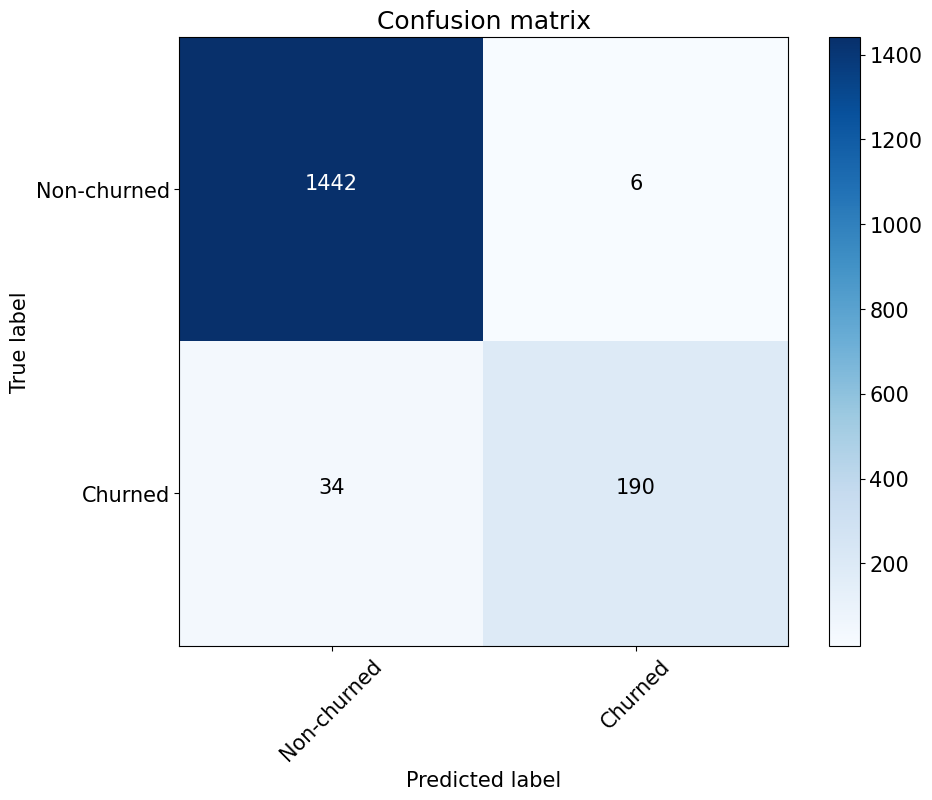

In [ ]:
# Опишите результаты при помощи confusion_matrix;
# нашел функцию тут - https://habr.com/ru/companies/ods/articles/328372/

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Нормализованная confusion matrix")
    else:
        print('Confusion matrix, без нормализации')


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, lr.predict(X_test))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')

In [ ]:
# Создание датафрейма с исходными данными
df_original = pd.DataFrame({
    'Message': df_text.loc[y_test.index, 'Message'].values,  # 1672 values
    'Actual': y_test.values,  # Фактические метки
    'Predicted': y_pred  # Предсказанные метки
})

# Выделение строк с неправильной классификацией
misclassified_df = df_original[df_original['Actual'] != df_original['Predicted']]
misclassified_df

,Message,Actual,Predicted
17,hey free call,ham,spam
40,reminder downloaded content already paid goto ...,spam,ham
47,guess somebody know secretly fancy wanna find ...,spam,ham
74,oh god found number glad text back xafter msg ...,spam,ham
84,next amazing xxx picsfree1 video sent enjoy on...,spam,ham
...,...,...,...
1525,freemsg hi baby wow got new cam moby wanna c h...,spam,ham
1567,important customer service announcement premier,spam,ham
1569,themob check newest selection content game ton...,spam,ham
1576,free call,ham,spam
